In [25]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import auc, balanced_accuracy_score, make_scorer, roc_curve, auc
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import xgboost as xgb

Uploading Kaggle dataset

In [2]:
#Load the dataset
from google.colab import files
file = files.upload()  #upload file into google colab session

ModuleNotFoundError: No module named 'google.colab'

Loading dataset

In [3]:
df = pd.read_csv("Customer_Behaviour.csv")

In [4]:
df.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


Data processing

In [5]:
# Dropping 'User ID' since it doesnt add value to the model
df.drop(['User ID'], axis = 1, inplace = True)

In [6]:
# Checking for null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Gender           400 non-null    object
 1   Age              400 non-null    int64 
 2   EstimatedSalary  400 non-null    int64 
 3   Purchased        400 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 12.6+ KB


In [7]:
# Checking for Data imbalance
class_counts = df['Purchased'].value_counts()
print("Class counts:")
print(class_counts)

Class counts:
0    257
1    143
Name: Purchased, dtype: int64


In [8]:
df.head()

,Gender,Age,EstimatedSalary,Purchased
0,Male,19,19000,0
1,Male,35,20000,0
2,Female,26,43000,0
3,Female,27,57000,0
4,Male,19,76000,0


In [9]:
# Define the possible values for each column
profession_values = np.array(['Healthcare', 'Engineer', 'Lawyer', 'Entertainment', 'Artist',
                             'Executive', 'Doctor', 'Homemaker', 'Marketing'])
ever_married_values = np.array(['No', 'Yes'])
spending_score_values = np.array(['Low', 'Average', 'High'])

# Set the number of rows for the DataFrame
num_rows = 400

# Randomly select values for each column
random_profession = np.random.choice(profession_values, size=num_rows)
random_ever_married = np.random.choice(ever_married_values, size=num_rows)
random_spending_score = np.random.choice(spending_score_values, size=num_rows)

# Create the DataFrame
df_new_cols = pd.DataFrame({
    'Profession': random_profession,
    'Ever_Married': random_ever_married,
    'Spending_Score': random_spending_score
})

In [10]:
# Converting Gender to a numeric to over sample
df_enc = pd.get_dummies(df,columns = ['Gender'])
df_enc.drop(['Gender_Male'], axis = 1, inplace = True)
df_enc.head()

,Age,EstimatedSalary,Purchased,Gender_Female
0,19,19000,0,0
1,35,20000,0,0
2,26,43000,0,1
3,27,57000,0,1
4,19,76000,0,0


In [11]:
df_new = pd.concat([df_enc, df_new_cols], axis=1)
df_new.head(2)

,Age,EstimatedSalary,Purchased,Gender_Female,Profession,Ever_Married,Spending_Score
0,19,19000,0,0,Engineer,Yes,Low
1,35,20000,0,0,Engineer,No,Low


In [12]:
df.to_csv('New Customer Data.csv', index=False)

In [13]:
df_new_enc = pd.get_dummies(df_new)
df_new_enc.drop(['Ever_Married_No'], axis = 1, inplace = True)
df_new_enc.head(2)

,Age,EstimatedSalary,Purchased,Gender_Female,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Ever_Married_Yes,Spending_Score_Average,Spending_Score_High,Spending_Score_Low
0,19,19000,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
1,35,20000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


Splitting the data

In [14]:
# Separating the parameters and the output
X = df_new_enc.copy()
X.drop(['Purchased'], axis = 1, inplace = True)
y = df["Purchased"]

# Training - to train the model
# Validation used to train the parameters of the model to get the best results
# Testing - to get the performance on data the model hasnt been trained on or had the parameters tuned on since that can lead to a bias

# Splitting into test and test+validation
X_train, X_tv, y_train, y_tv = train_test_split(X, y, train_size=0.60,
                                                    stratify=y)

# Splitting test+validation into separate testing and valdiation sets
X_test, X_val, y_test, y_val = train_test_split(X_tv, y_tv, train_size=0.50,
                                                    stratify=y_tv)

# Naming the columns in the split dataset to the original
X_train.columns = X.columns
X_test.columns = X.columns
X_val.columns = X.columns

In [15]:
# Opted for a 60:20:20 split
print('Train:',X_train.shape)
print('Test:',X_test.shape)
print('Validation:',X_val.shape)

Train: (240, 16)
Test: (80, 16)
Validation: (80, 16)


In [16]:
# Getting class counts on Training data
class_counts = y_train.value_counts()
print("Class counts:")
print(class_counts)

Class counts:
0    154
1     86
Name: Purchased, dtype: int64


Oversampling Training set using SMOTE

In [17]:
from imblearn.over_sampling import SMOTE

In [18]:
# SMOTE creates new data points based on the existing ones instead of just duplicating random points
smote = SMOTE()
X_train_os, y_train_os = smote.fit_resample(X_train, y_train)

In [19]:
# Post oversampling class divison
class_counts = y_train_os.value_counts()
print("Class counts:")
print(class_counts)

Class counts:
1    154
0    154
Name: Purchased, dtype: int64


## Model training

In [20]:
# XGboost model
xgb_classifier = xgb.XGBClassifier()

In [21]:
param_grid = {
    'max_depth': [1,2,3,4,5,6,7],
    'learning_rate': [0.1, 0.01, 0.05],
    'n_estimators': [100, 200, 300, 400]
}

In [22]:
# Perform grid search with cross-validation on the validation set
scorer = make_scorer(balanced_accuracy_score)
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5, scoring=scorer)
grid_search.fit(X_val, y_val)

# Get the best parameters and model
best_params = grid_search.best_params_
print(best_params)
best_model = grid_search.best_estimator_

# Train the model on the training set with the best parameters
best_model.fit(X_train_os, y_train_os)

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate accuracy on the test set
accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy:", accuracy)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 300}
Test set accuracy: 0.925
              precision    recall  f1-score   support

           0       0.98      0.90      0.94        51
           1       0.85      0.97      0.90        29

    accuracy                           0.93        80
   macro avg       0.91      0.93      0.92        80
weighted avg       0.93      0.93      0.93        80

[[46  5]
 [ 1 28]]


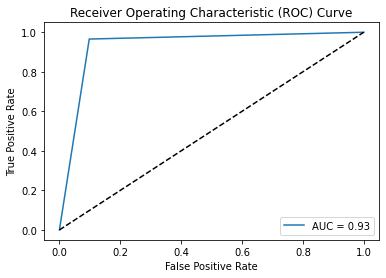

In [23]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate the AUC (Area Under the Curve) score
auc_score = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Exporting the model

In [26]:
import joblib

# Saving the model to a file
joblib.dump(best_model, 'customer_behavior_model.pkl')

['customer_behavior_model.pkl']

In [27]:
loaded_model = joblib.load('customer_behavior_model.pkl')

prediction for new data

In [ ]:
import pandas as pd
import joblib

In [ ]:
def make_prediction(new_data):
    # All the columns that are expected by the model
    cols = ['Age', 'EstimatedSalary', 'Gender_Female', 'Profession_Artist',
            'Profession_Doctor', 'Profession_Engineer', 'Profession_Entertainment',
            'Profession_Executive', 'Profession_Healthcare', 'Profession_Homemaker',
            'Profession_Lawyer', 'Profession_Marketing', 'Ever_Married_Yes',
            'Spending_Score_Average', 'Spending_Score_High', 'Spending_Score_Low']

    # Encoding the categorical variables and adding the missing columns
    new_data_enc = pd.get_dummies(new_data, columns=['Gender', 'Profession', 'Ever_Married', 'Spending_Score'])
    new_data_enc = new_data_enc.reindex(columns=cols, fill_value=0)

    # Loading the model from the file
    loaded_model = joblib.load('TrainedModel.pkl')

    # Making predictions
    predictions = loaded_model.predict(new_data_enc)

    return bool(predictions[0])  # Convert 0/1 to True/False

In [ ]:
# Sample of a new row of data
new_data = pd.DataFrame({
    'Age': [39],
    'EstimatedSalary': [190000],
    'Purchased': [0],
    'Gender': ['Male'],
    'Profession': ['Lawyer'],
    'Ever_Married': ['Yes'],
    'Spending_Score': ['High']
})

In [ ]:
result = make_prediction(new_data)
print(result)

Prediction: True
